In [1]:
# DigiTech Smart House Predictive Model
# This script implements a predictive model for improving indoor air quality,
# energy efficiency, and occupant comfort using real-time environmental sensor data.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from google.colab import files
import io

In [2]:
# Step 1: Data Loading and Preprocessing
try:
    data = pd.read_csv('smarthouse.csv') # Load real-time sensor data for the DigiTech Smart House
    # Parse and format the timestamp correctly for temporal analysis
    # Changed the date format to match the data in the CSV file
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d/%m/%Y %H:%M')
    data.set_index('Timestamp', inplace=True)
except FileNotFoundError:
    print("File not found. Please check the file path.")
except KeyError:
    print("Timestamp column is missing or improperly formatted.")

In [3]:
# Handle missing values through time interpolation and forward fill as a fallback method
data.interpolate(method='time', inplace=True)
data.ffill(inplace=True)   # Forward fill any remaining NaN values


In [4]:
# Step 2: Outlier Detection using Isolation Forest
# Isolation Forest is used to remove outliers in temperature and humidity data
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05)  # Detect 5% of data as outliers
outliers = iso_forest.fit_predict(data[['Temperature', 'Humidity']])
data_cleaned = data[outliers == 1]  # Retain only non-outlier data


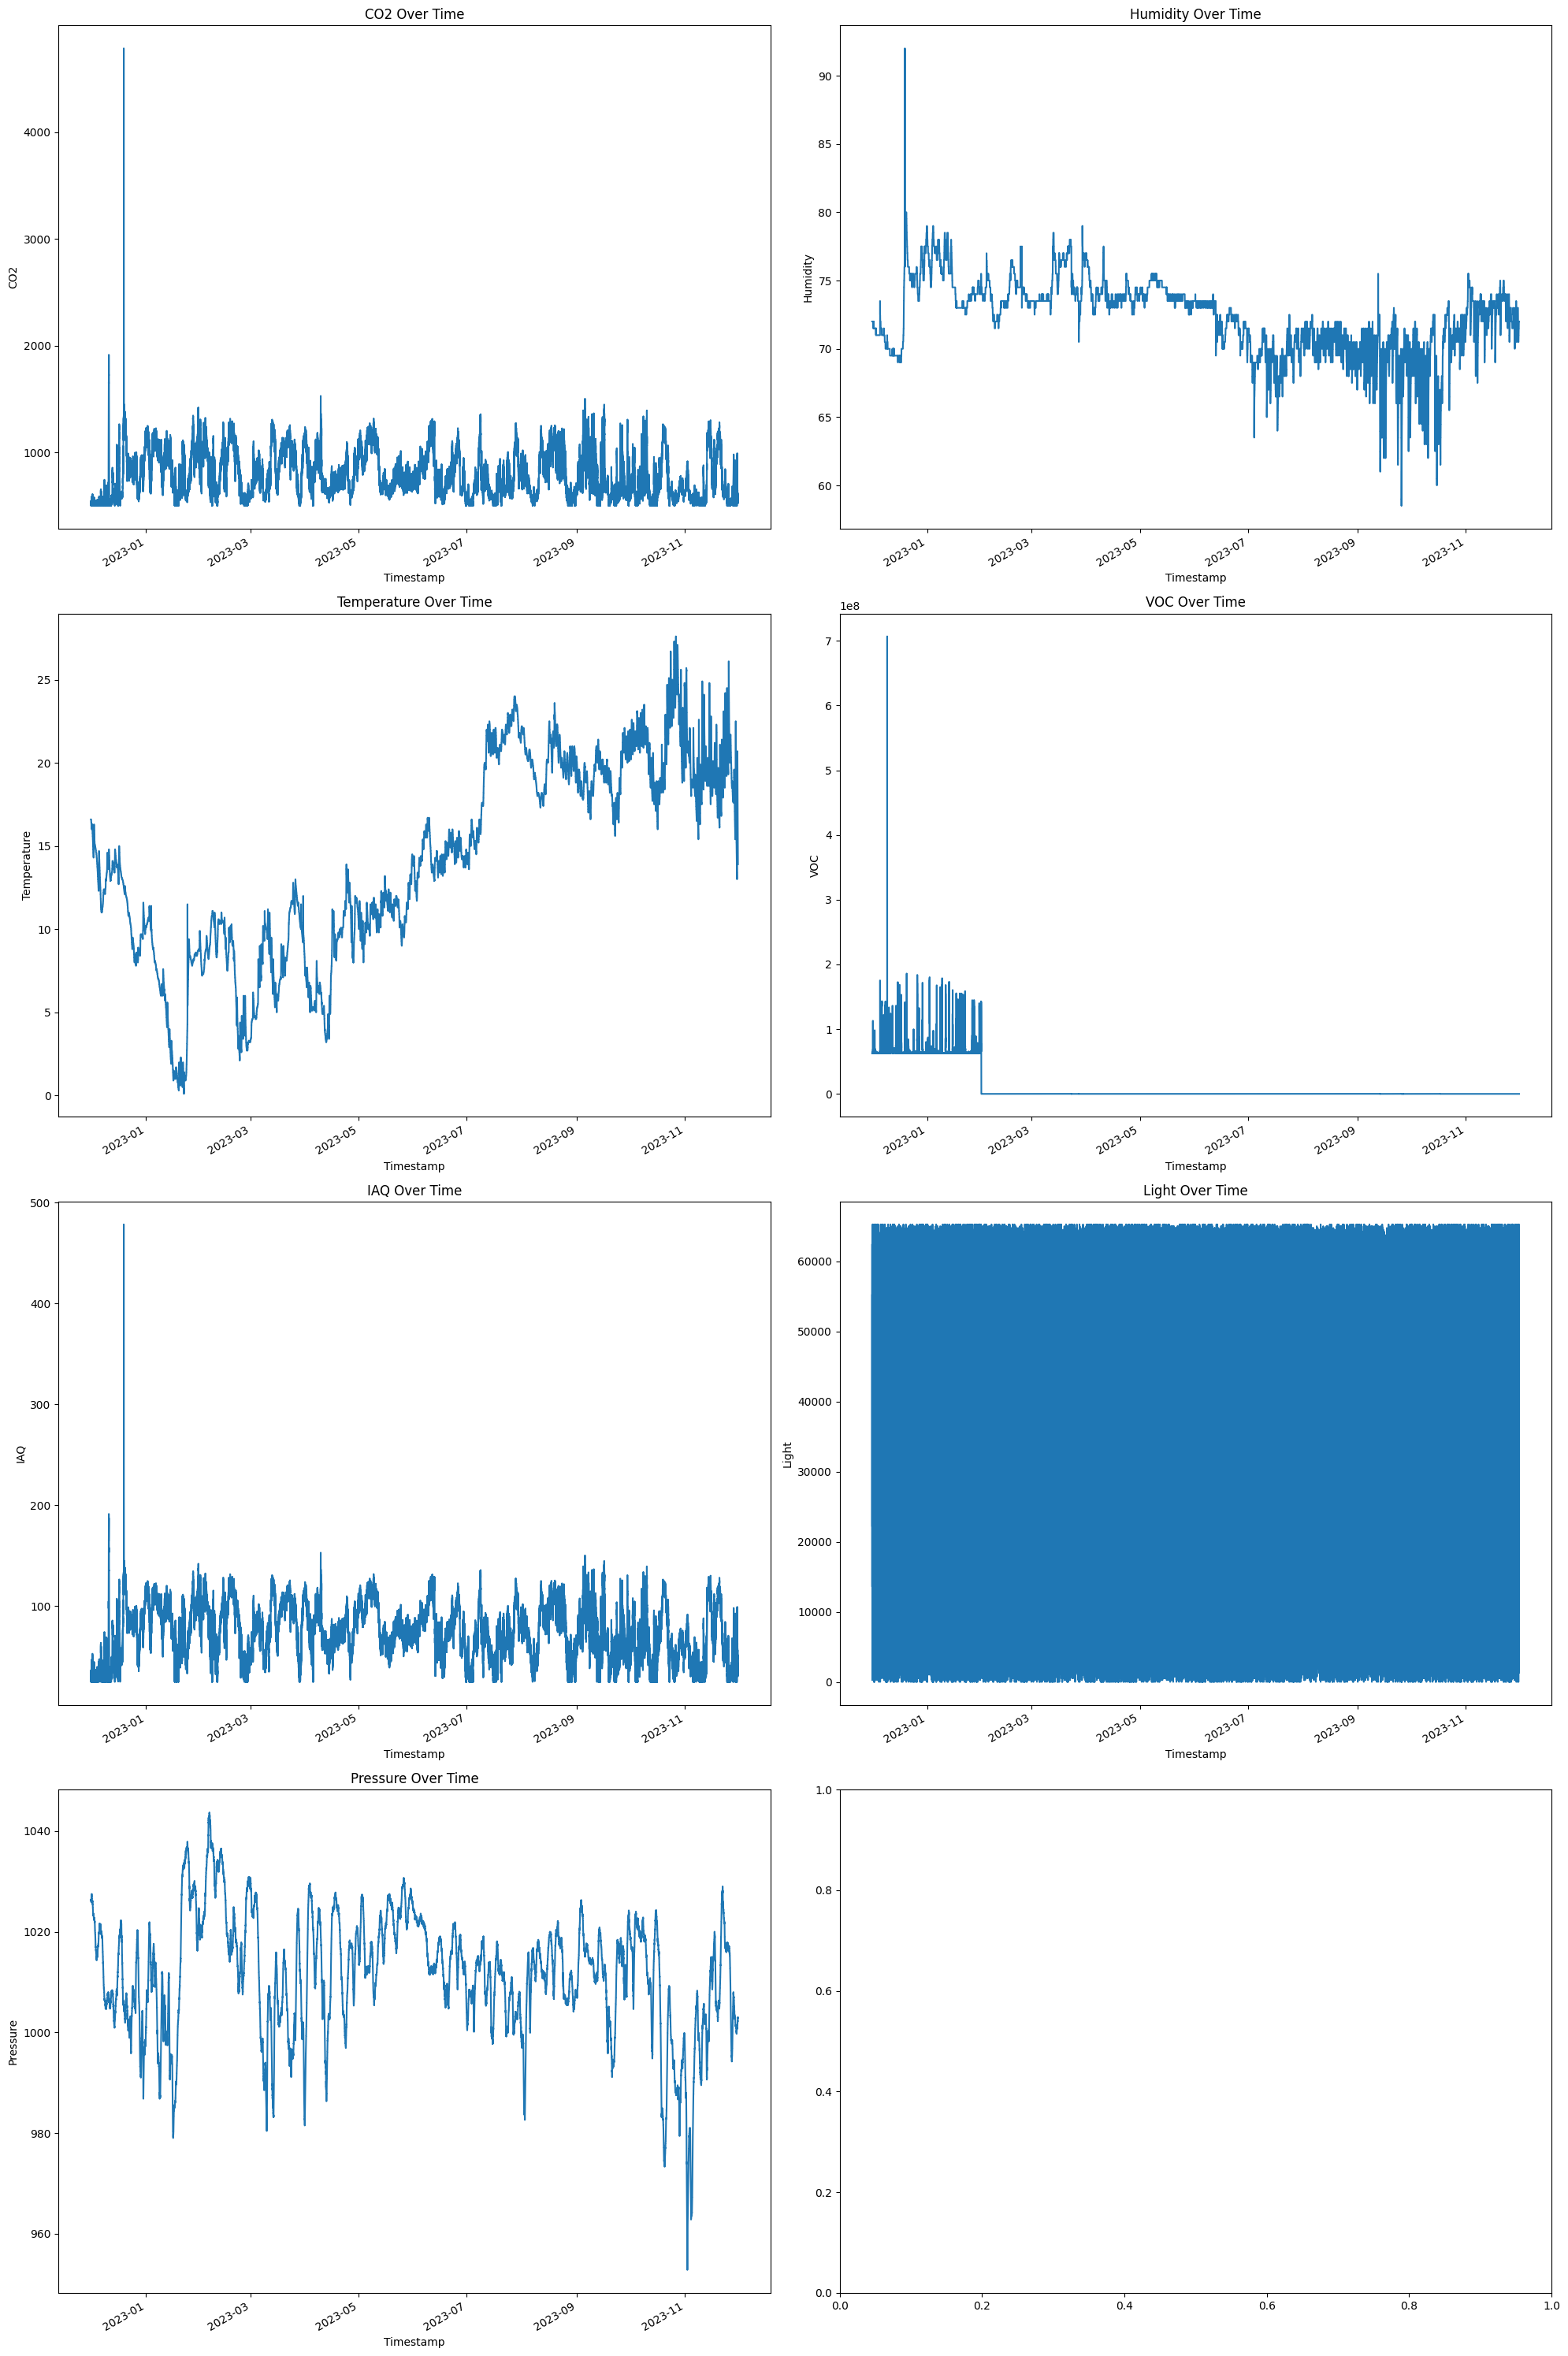

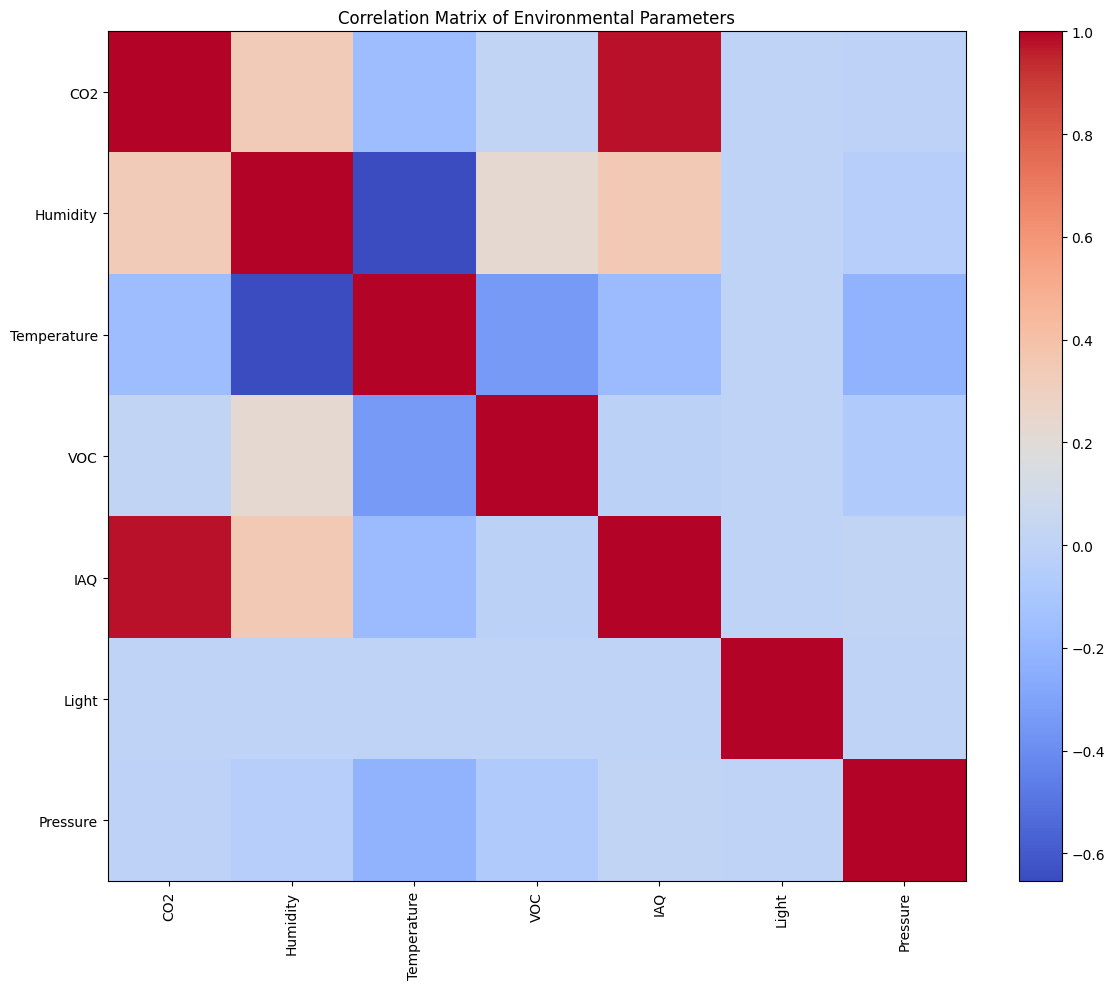

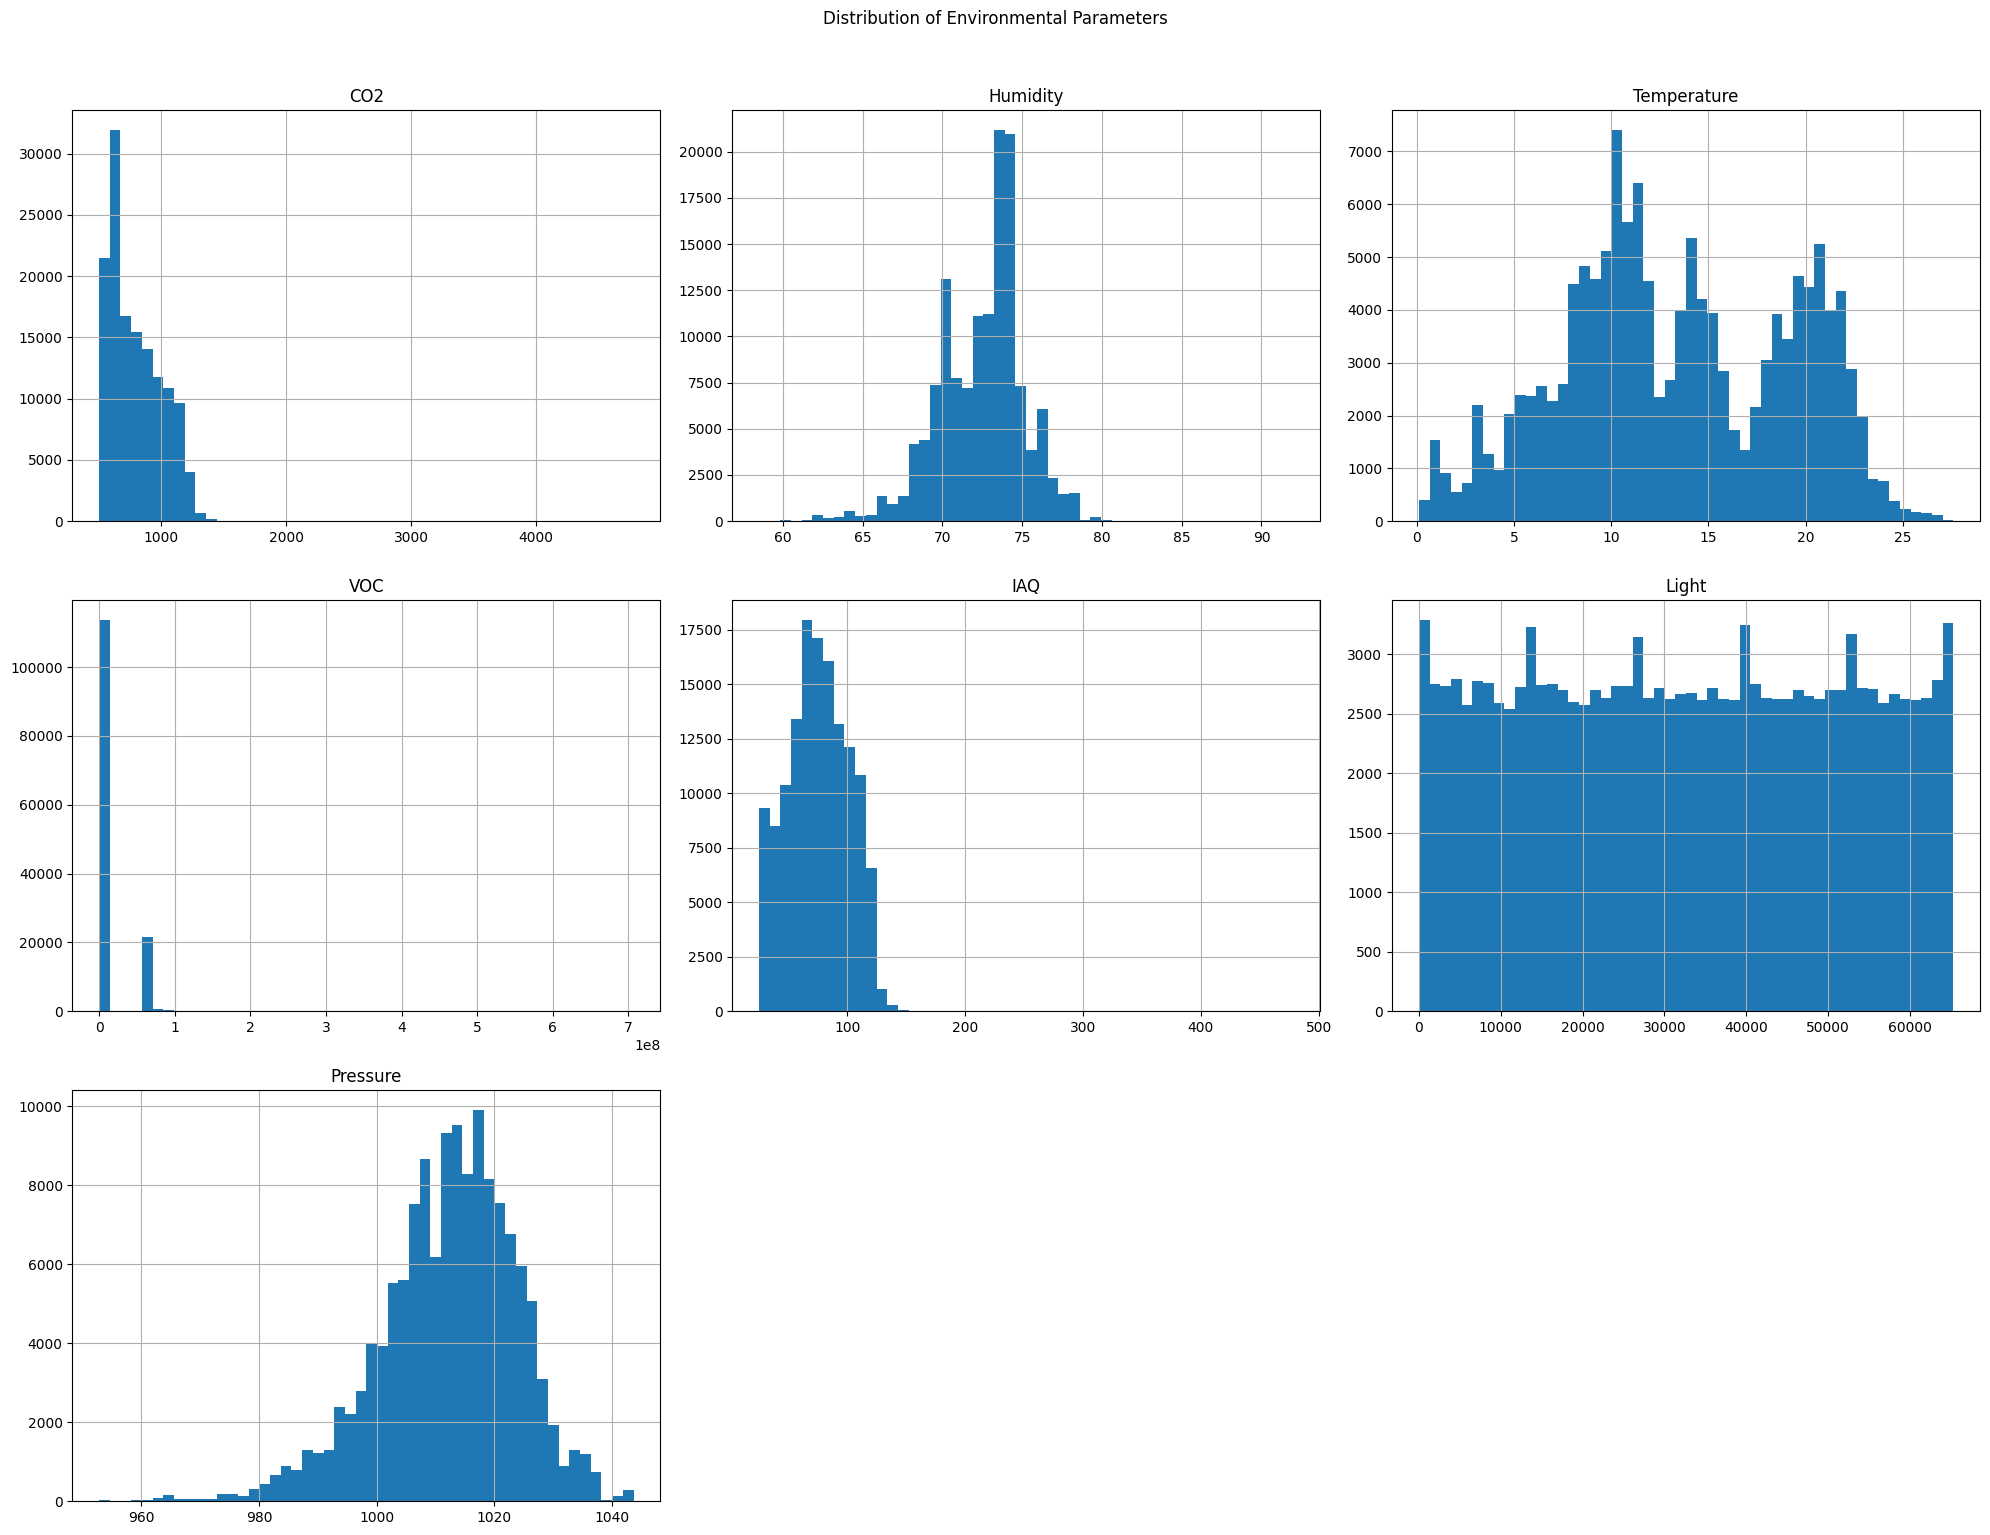

In [5]:
# Step 3: Exploratory Data Analysis (EDA)
def perform_eda(df):
    """
    Perform exploratory data analysis (EDA) on environmental parameters.
    Includes time-series plotting, correlation matrix, and data distribution.
    """
    # Parameters to analyze: CO2, Humidity, Temperature, VOC, IAQ, Light, Pressure

    # Analyze temporal patterns for all relevant parameters

    parameters = ['CO2', 'Humidity', 'Temperature', 'VOC', 'IAQ', 'Light', 'Pressure']

  # Visualizing temporal trends in each parameter

    fig, axes = plt.subplots(4, 2, figsize=(20, 30))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

    for i, param in enumerate(parameters):
        df[param].plot(ax=axes[i], title=f'{param} Over Time')
        axes[i].set_xlabel('Timestamp')
        axes[i].set_ylabel(param)

    plt.tight_layout()
    plt.show()

    # Correlation matrix to identify relationships between parameters
    correlation_matrix = df[parameters].corr()
    plt.figure(figsize=(12, 10))
    plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
    plt.title('Correlation Matrix of Environmental Parameters')
    plt.tight_layout()
    plt.show()

  # Plot histogram for the distribution of each parameter
    df[parameters].hist(figsize=(20, 15), bins=50)
    plt.suptitle("Distribution of Environmental Parameters", y=1.02)
    plt.tight_layout()
    plt.show()

perform_eda(data)

In [6]:
# Step 4: Feature Engineering (Time-based features)
# Create lag features to capture temporal patterns (e.g., lags of 1, 2, and 3 hours)
for lag in range(1, 4):  # Lags of 1, 2, and 3 hours
    data[f'CO2_lag_{lag}'] = data['CO2'].shift(lag)


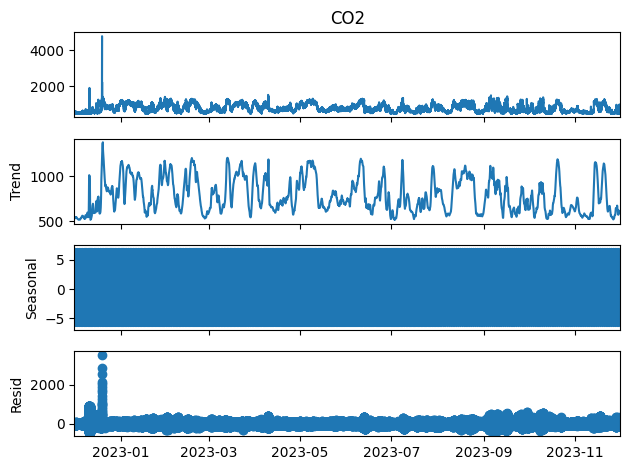

In [7]:
# Seasonal decomposition to identify trends and seasonal components in CO2 levels
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition
decomposition = seasonal_decompose(data['CO2'], model='additive', period=365)
decomposition.plot()
plt.show()


In [8]:
# Step 5: Prepare Data for Modeling
# Extract relevant features for prediction (including temporal features like hour, day of week)

from sklearn.preprocessing import MinMaxScaler # import the MinMaxScaler

features = ['CO2', 'Humidity', 'Temperature', 'VOC', 'IAQ', 'Light', 'hour', 'day_of_week', 'month']
target = ['CO2', 'Temperature', 'Humidity']  # Example target variables

# Extract temporal features if 'Timestamp' column exists
if 'Timestamp' in data.columns:
    data['hour'] = data['Timestamp'].dt.hour
    data['day_of_week'] = data['Timestamp'].dt.dayofweek
    data['month'] = data['Timestamp'].dt.month
else:
    # Handle the case where 'Timestamp' column doesn't exist
    # For example, create these features based on other columns or set them to default values
    data['hour'] = 0  # Example: Set a default value
    data['day_of_week'] = 0  # Example: Set a default value
    data['month'] = 1  # Example: Set a default value

X = data[features] # Feature matrix
y = data[target] # Target matrix


# Step 6: Split Data using TimeSeriesSplit (for time-series prediction)
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

 # Step 7: Scaling the data using MinMaxScaler for model training
    scaler = MinMaxScaler() # initialize the MinMaxScaler within the loop
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

In [9]:
# Step 8: Train a RandomForest Regressor (Energy efficiency prediction)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set and evaluate the model
rf_predictions = rf_model.predict(X_test_scaled)

# Define the evaluation function to calculate RMSE and MAE
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

rf_rmse, rf_mae = evaluate_model(y_test, rf_predictions)
print(f"Random Forest - RMSE: {rf_rmse}, MAE: {rf_mae}")

Random Forest - RMSE: 1.3036376119310196, MAE: 0.677504240937823


XGBoost - RMSE: 1.4969596126095024, MAE: 0.26432378725176553


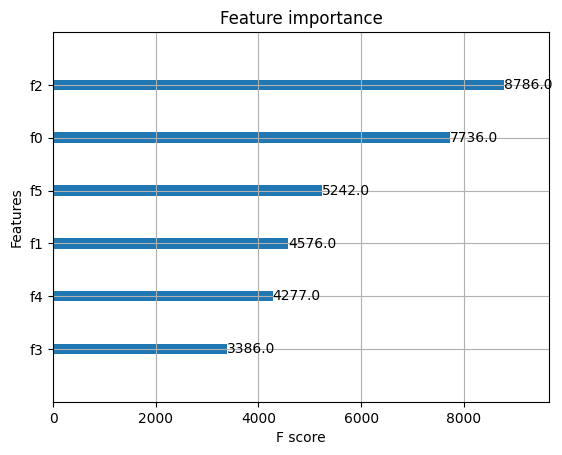

In [13]:
# Step 9: XGBoost Model for CO2, Temperature, Humidity prediction
from xgboost import XGBRegressor, plot_importance # import the XGBRegressor class and plot_importance function from the xgboost library

xgb_model = XGBRegressor(
    colsample_bytree=1.0,
    learning_rate=0.05,
    max_depth=7,
    n_estimators=300,
    subsample=1.0,
    reg_alpha=0.1,
    reg_lambda=0.1
)
xgb_model.fit(X_train_scaled, y_train)

# Predict and evaluate XGBoost model
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_rmse, xgb_mae = evaluate_model(y_test, xgb_predictions)
print(f"XGBoost - RMSE: {xgb_rmse}, MAE: {xgb_mae}")

# Plot feature importance for XGBoost
plot_importance(xgb_model)
plt.show()

0.0 1.0000000000000002


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3425/3425 ━━━━━━━━━━━━━━━━━━━━ 104s 29ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 9.2741e-05 - val_mean_squared_error: 9.2741e-05
Epoch 2/50
3425/3425 ━━━━━━━━━━━━━━━━━━━━ 144s 30ms/step - loss: 1.2925e-04 - mean_squared_error: 1.2925e-04 - val_loss: 6.6600e-05 - val_mean_squared_error: 6.6600e-05
Epoch 3/50
3425/3425 ━━━━━━━━━━━━━━━━━━━━ 156s 34ms/step - loss: 1.0677e-04 - mean_squared_error: 1.0677e-04 - val_loss: 5.0370e-05 - val_mean_squared_error: 5.0370e-05
Epoch 4/50
3425/3425 ━━━━━━━━━━━━━━━━━━━━ 132s 31ms/step - loss: 1.1651e-04 - mean_squared_error: 1.1651e-04 - val_loss: 5.4853e-05 - val_mean_squared_error: 5.4853e-05
Epoch 5/50
3425/3425 ━━━━━━━━━━━━━━━━━━━━ 141s 31ms/step - loss: 8.8674e-05 - mean_squared_error: 8.8674e-05 - val_loss: 5.7130e-05 - val_mean_squared_error: 5.7130e-05
Epoch 6/50
3425/3425 ━━━━━━━━━━━━━━━━━━━━ 136s 29ms/step - loss: 8.5001e-05 - mean_squared_error: 8.5001e-05 - val_loss: 5.8827e-05 - val_mean_squared_error: 5.882

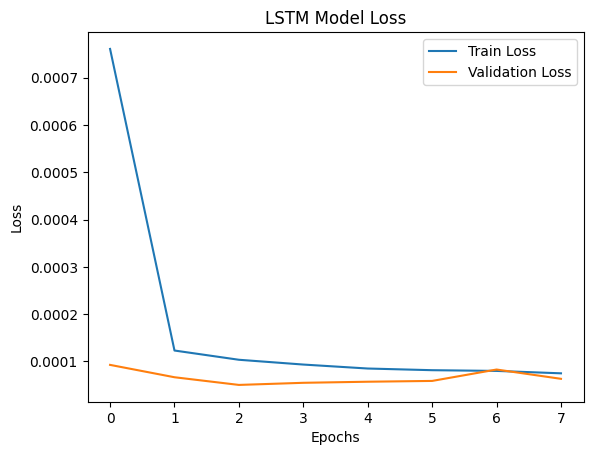

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Future Predictions:  [[0.00905892]
 [0.00927795]
 [0.00865474]
 [0.00879697]
 [0.00881578]
 [0.00861028]
 [0.00863014]
 [0.00874373]
 [0.00811654]
 [0.00780153]]


In [14]:
# Step 10: Train LSTM Model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal


# Load and preprocess the dataset
data = pd.read_csv('smarthouse.csv')
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d/%m/%Y %H:%M')
data.set_index('Timestamp', inplace=True)

# Interpolate missing values and forward-fill any remaining NaN values
data.interpolate(method='time', inplace=True)
data.ffill(inplace=True)

# Create lag features for temporal patterns
for lag in range(1, 4):  # Lags of 1, 2, and 3 hours
    data[f'CO2_lag_{lag}'] = data['CO2'].shift(lag)

# Drop NaN values after creating lags
data.dropna(inplace=True)

# Feature Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Check if all scaled data is within the range [0, 1]
print(scaled_data.min(), scaled_data.max())

# Prepare sequences for LSTM (define sequence length)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Predicting the 'CO2' value
    return np.array(X), np.array(y)

SEQ_LENGTH = 24  # Use the last 24 hours as the sequence length
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split the data into training and validation sets (80% train, 20% validation)
train_size = int(X.shape[0] * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# LSTM Model with Dropout for Regularization
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2]), kernel_initializer=HeNormal()))
model.add(Dropout(0.2))  # Dropout layer to reduce overfitting
model.add(LSTM(32, kernel_initializer=HeNormal()))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for predicting 'CO2'

# Compile the model with a lower learning rate and gradient clipping
model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mean_squared_error', metrics=['mean_squared_error'])

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with a smaller batch size and early stopping
history = model.fit(
    X_train, y_train,
    epochs=50,  # Increased epoch count, but with early stopping
    batch_size=32,  # Tuned batch size
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model performance on validation data
y_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
val_mae = mean_absolute_error(y_val, y_pred)
print(f"LSTM Model - Validation RMSE: {val_rmse}, MAE: {val_mae}")

# Plot training history (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#  Make predictions on new data (test or future data)
y_future_pred = model.predict(X_val[-10:])  # Predict future values using the last 10 validation sequences
print("Future Predictions: ", y_future_pred)


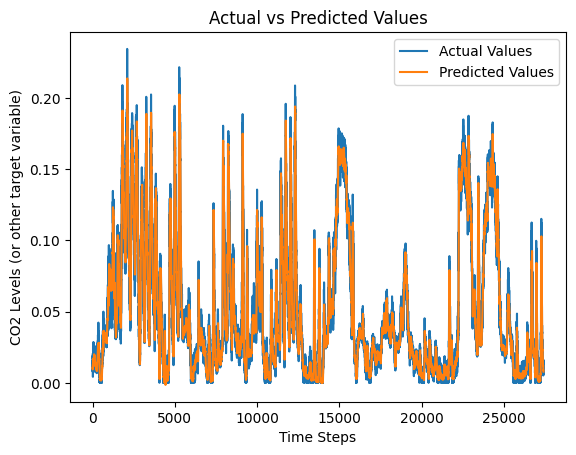

In [18]:
# Plot actual vs predicted values
plt.plot(y_val, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('CO2 Levels (or other target variable)')
plt.legend()
plt.show()


In [21]:
# Inverse transform the predictions for the 'CO2' column (first feature)

# Create a dummy array of zeros with the same shape as the original scaled data
# This ensures the scaler can handle the full feature set
dummy_input = np.zeros((y_future_pred.shape[0], scaled_data.shape[1]))

# Insert the predicted 'CO2' values into the first column of the dummy array
# We assume the model is predicting 'CO2' which was in the first column
dummy_input[:, 0] = y_future_pred[:, 0]

# Apply inverse_transform to the entire dummy array to scale the values back to the original range
# The scaler expects the same number of columns as the original dataset
y_future_pred_rescaled = scaler.inverse_transform(dummy_input)

# Extract the first column (corresponding to 'CO2') from the rescaled values
# This gives us the real-world predictions for 'CO2' in its original scale
y_future_pred_rescaled = y_future_pred_rescaled[:, 0]

# Print the rescaled predictions for 'CO2'
print("Rescaled Future Predictions (CO2): ", y_future_pred_rescaled)


Rescaled Future Predictions (CO2):  [538.80842412 539.74672601 537.07692087 537.68620905 537.76680273
 536.88643253 536.97152668 537.45815289 534.77127147 533.42173436]
